In [6]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"emelinevanderbeken","key":"fdef7825bb20ad21c25fc469ea16f6fd"}'}

In [7]:
! cp kaggle.json ~/.kaggle/

In [8]:
! chmod 600 ~/.kaggle/kaggle.json

In [9]:
! kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

 19% 5.00M/25.7M [00:00<00:00, 43.9MB/s]
100% 25.7M/25.7M [00:00<00:00, 102MB/s] 


In [10]:
! mkdir data
! unzip imdb-dataset-of-50k-movie-reviews.zip -d data

Archive:  imdb-dataset-of-50k-movie-reviews.zip
  inflating: data/IMDB Dataset.csv   


We load the modules and libraries required for the model.

In [45]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.model_selection import StratifiedShuffleSplit
import pickle
import warnings
import spacy
en_nlp = spacy.load('en')

In [12]:
my_filepath="data/IMDB Dataset.csv"
reviews = pd.read_csv(my_filepath)
print(reviews.columns)
print(reviews.info())

Index(['review', 'sentiment'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB
None


 We examine the first rows.

In [13]:
reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


negative    25000
positive    25000
Name: sentiment, dtype: int64


<Figure size 864x432 with 0 Axes>

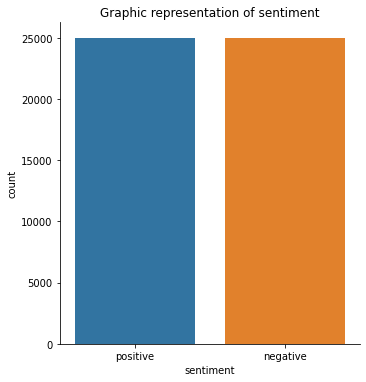

In [14]:
print(reviews.sentiment.value_counts())
plt.figure(figsize=(12,6))
sns.catplot(x='sentiment', kind='count', data = reviews)
plt.title('Graphic representation of sentiment')
plt.show()

 Reviews are classified as positive or negative. We have a perfecltly balanced dataset.

In [15]:
X=reviews.review
y=reviews.sentiment
reviewsNb=len(X)
print('First review:\n {}'.format(X[0]))
print('Last review:\n {}'.format(X[reviewsNb-1]))

First review:
 One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is

We notice that reviews exhibit characters corresponding to html lines breaks. We clean the data.

In [18]:
X_clean=pd.Series([rev.replace("<br />"," ") for rev in X],name='review')
X_clean.head()

0    One of the other reviewers has mentioned that ...
1    A wonderful little production.   The filming t...
2    I thought this was a wonderful way to spend ti...
3    Basically there's a family where a little boy ...
4    Petter Mattei's "Love in the Time of Money" is...
Name: review, dtype: object

In [19]:
print('First review:\n {}'.format(X_clean[0]))
print('Last review:\n {}'.format(X_clean[reviewsNb-1]))

First review:
 One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.  The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.  It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.  I would say the main appeal of the show is due to the fact that it goes 

In [46]:
def evaluate_model(model,X_clean,y):
  X_train,X_test,y_train,y_test=train_test_split(X_clean, y, train_size=0.8, test_size=0.2,
                                                      random_state=0)
  model.fit(X_train,y_train)
  print("Accuracy score on training set {}".format(model.score(X_train,y_train)))
  print("Accuracy score on test set {}".format(model.score(X_test,y_test)))

def post_processing(model,token):
  feature_names = model[token].get_feature_names()
  coeff_lg=model['lg'].coef_
  print("Number of features: {}".format(len(feature_names)))
  feature_to_coef = {word: coef for word,coef in zip(feature_names,coeff_lg[0])}
  print("The 5 most discriminating words for positive reviews are")
  for best_positive in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1], 
    reverse=True)[:5]:
    print (best_positive)
  print("The 5 most discriminating words for negative reviews are")
  for best_negative in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1])[:5]:
    print (best_negative)
  neg_coeff=dict(sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1])[:20])
  pos_coeff=dict(sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1],reverse=True)[:20])
  pos_coeff=dict(sorted(pos_coeff.items(),key=lambda x: x[1]))
  plt.figure(figsize=(20,6))
  plt.xticks(rotation=45)
  plt.bar(neg_coeff.keys(), neg_coeff.values())
  plt.bar(pos_coeff.keys(), pos_coeff.values())
  plt.show()

def custom_tokenizer(document):
    doc_spacy = en_nlp(document)
    return [token.lemma_ for token in doc_spacy]

# Mute warnings
warnings.filterwarnings('ignore')  

We use a Count Vectorizer as tokenizer. We train a logistic regression.

In [31]:
cv_pipe=Pipeline([('cvec',CountVectorizer(min_df=5)),('lg',LogisticRegression(C=0.1,max_iter=500))])
evaluate_model(cv_pipe,X_clean,y)

Accuracy score on training set 0.966275
Accuracy score on test set 0.8897


Number of features: 33685
The 5 most discriminating words for positive reviews are
('excellent', 0.8948996449659399)
('refreshing', 0.8362995387967026)
('superb', 0.8321481651472157)
('perfect', 0.803107589123064)
('funniest', 0.7843386324008403)
The 5 most discriminating words for negative reviews are
('waste', -1.51126708153417)
('worst', -1.508453071826053)
('awful', -1.1288570615947335)
('poorly', -1.053074156689215)
('disappointment', -1.0529214592609106)


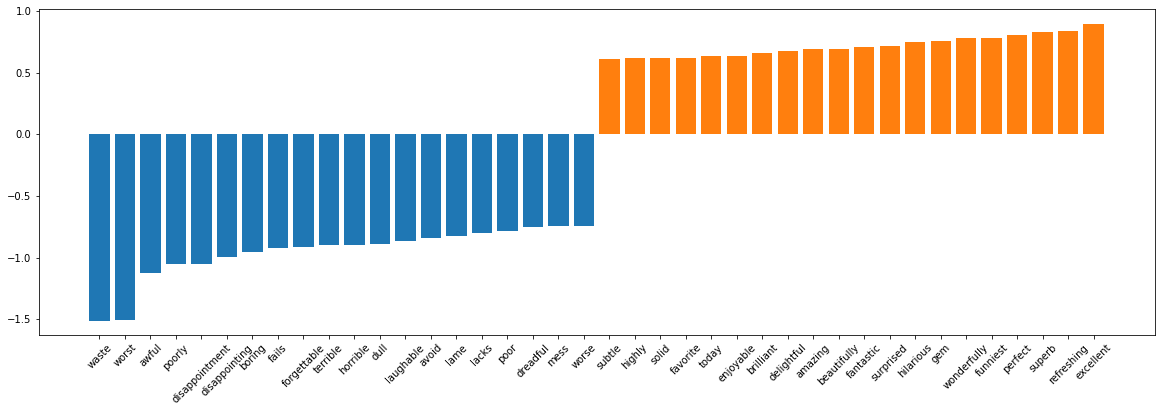

In [43]:
post_processing(cv_pipe,'cvec')

We now use a TFIDF Vectorizer.

In [32]:
tfidf_pipe=Pipeline([('tvec',TfidfVectorizer(min_df=5)),('lg',LogisticRegression(C=0.1,max_iter=500))])
evaluate_model(tfidf_pipe,X_clean,y)

Accuracy score on training set 0.879325
Accuracy score on test set 0.8599


Number of features: 33685
The 5 most discriminating words for positive reviews are
('great', 4.472443858955175)
('excellent', 2.7437821537009746)
('and', 2.7181931555182848)
('best', 2.696574912486394)
('love', 2.3436596422193463)
The 5 most discriminating words for negative reviews are
('bad', -5.18929143708149)
('worst', -4.152055848264253)
('awful', -2.862806418953737)
('waste', -2.8056456323612373)
('no', -2.7129979853752584)


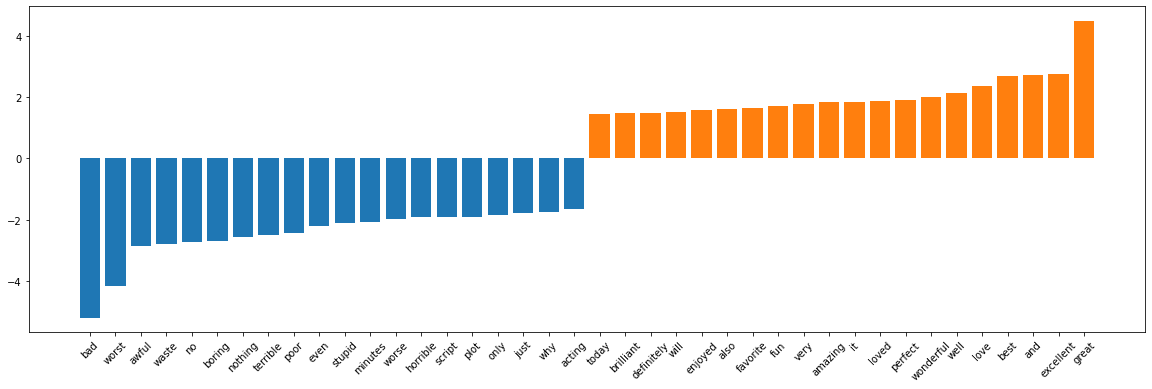

In [44]:
post_processing(tfidf_pipe,'tvec')

In [47]:
lemma_cv_pipe=Pipeline([('cvec',CountVectorizer(tokenizer=custom_tokenizer)),('lg',LogisticRegression(C=0.1,max_iter=500))])
evaluate_model(lemma_cv_pipe,X_clean,y)

Accuracy score on training set 0.96485
Accuracy score on test set 0.8952


Number of features: 98091
The 5 most discriminating words for positive reviews are
('7/10', 1.705717216329588)
('8/10', 1.239284109670798)
('excellent', 0.9192556859334905)
('superb', 0.888393889821903)
('7', 0.8603660243313556)
The 5 most discriminating words for negative reviews are
('4/10', -1.643768549204456)
('waste', -1.3091532636652063)
('awful', -1.1177471550806037)
('3/10', -1.053435704661578)
('disappointment', -1.0318109839417364)


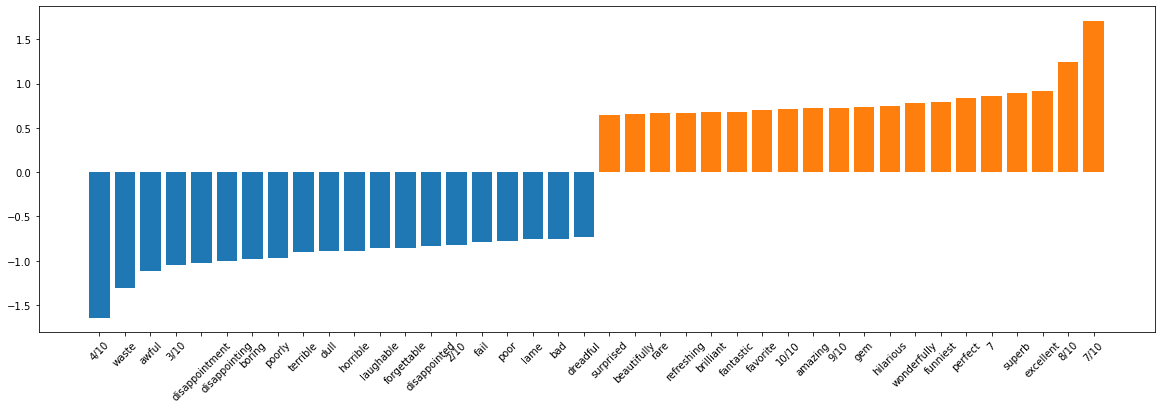

In [48]:
post_processing(lemma_cv_pipe,'cvec')

In [49]:
lemma_tfidf_pipe=Pipeline([('tvec',TfidfVectorizer(tokenizer=custom_tokenizer,stop_words='english')),('lg',LogisticRegression(C=0.1,max_iter=500))])
evaluate_model(lemma_tfidf_pipe,X_clean,y)

Accuracy score on training set 0.873875
Accuracy score on test set 0.8559


Number of features: 97791
The 5 most discriminating words for positive reviews are
('great', 4.784880437496984)
('love', 3.2710006267612024)
('excellent', 2.9546286967445217)
('good', 2.638825748333408)
('wonderful', 2.1805876430728284)
The 5 most discriminating words for negative reviews are
('bad', -7.520404488346004)
('waste', -3.9022777961034207)
('?', -3.8066940684087798)
('awful', -2.940273714953376)
('boring', -2.6211149603748476)


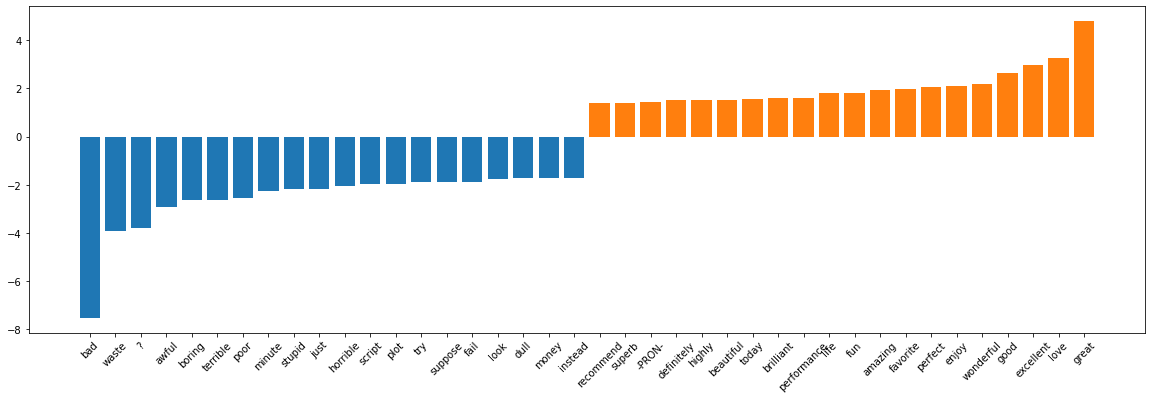

In [50]:
post_processing(lemma_tfidf_pipe,'tvec')

In [ ]:
# Setting params for TFIDF Vectorizer gridsearch
tfidf_params = {
 'tvec__min_df':[1,5,10], 
 'tvec__max_features':[100, 2000],
 'tvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
 'tvec__stop_words': [None, 'english'],
 'lg__C':[0.1,1,10],
}
lemma_tfidf_gs=GridSearchCV(lemma_tfidf_pipe,param_grid=tfidf_params,cv=5,verbose=1,n_jobs=-1)
#Fitting TFIDF Vectorizer with lemmatization GS
lemma_tfidf_gs.fit(X_train,y_train)
print("Best cross-validation score "
"(TFIDF Vectorizer with lemmatization): {:.3f}".format(lemma_tfidf_gs.best_score_))

In [51]:
lemma_tfidf_ngram_pipe=Pipeline([('tvec',TfidfVectorizer(tokenizer=custom_tokenizer,min_df=5,stop_words='english',ngram_range=(1, 2))),('lg',LogisticRegression(C=0.1,max_iter=500))])
evaluate_model(lemma_tfidf_ngram_pipe,X_clean,y)

Accuracy score on training set 0.87725
Accuracy score on test set 0.8539


Number of features: 156392
The 5 most discriminating words for positive reviews are
('great', 4.25052814288301)
('love', 2.9162526154950084)
('excellent', 2.48397722007198)
('good', 2.1641351031411564)
('wonderful', 1.8752077337732316)
The 5 most discriminating words for negative reviews are
('bad', -6.883855676164858)
('?', -3.83100955683378)
('waste', -3.24709370473497)
('awful', -2.4718670218427485)
('terrible', -2.209778671654352)


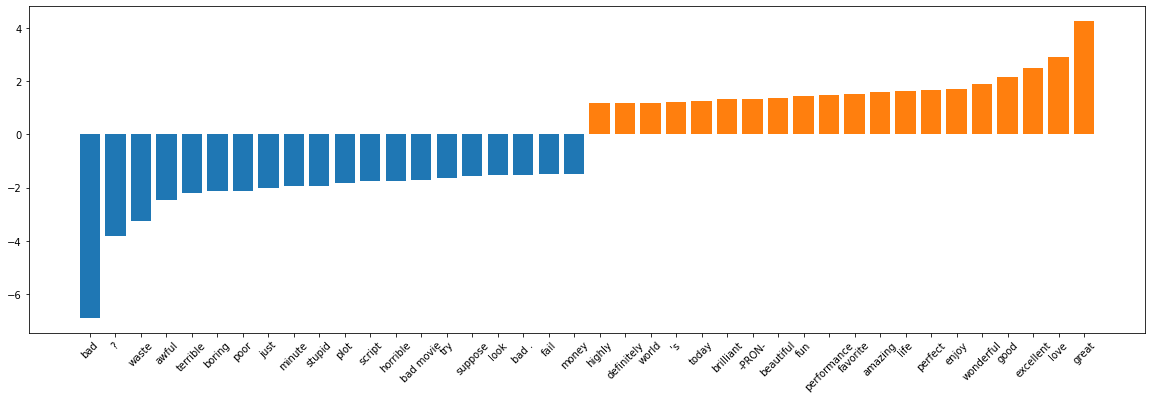

In [52]:
post_processing(lemma_tfidf_ngram_pipe,'tvec')